In [176]:
import numpy as np
import scipy
from scipy.special import erfc
from magnons.dipolar_sums import f,misra, Dkxx,Dkyy, Dkzz, Dkxy, Dkxz, Dkyz
from magnons.amplitudes import AkBkAngle, Jk
import matplotlib.pyplot as plt
from magnons.yig import a, mu,S,J

H = 2400.0
h = mu * H
eps = a**(-2)


In [14]:
p = np.random.rand(10,10,9)
q = np.random.rand(10,10,9)


In [15]:
%timeit f(p,q)

94.6 µs ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit misra(q)

82.2 µs ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
K = Dkxx(eps, a, mu)

In [22]:
x = np.arange(-100, 0, 1) * a
%timeit K.real_sum(x, 10**4, 10**4)

1.34 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit K.recip_sum(x, 10**4, 10**4)

2.04 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%timeit [K.real_sum_explicit(y, 10**4, 10**4) for y in x]

155 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%timeit K.table(10**2, 10**2, 400)

21.9 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit AkBkAngle(10**2, 10**2, np.radians(18), np.radians(30),N=400, J=J, S=S, h=h, eps=eps,a=a, mu=mu)

5.92 s ± 1.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [161]:
def AkBk(ky,
         kz,
         N=None,
         J=None,
         S=None,
         h=None,
         eps=None,
         a=None,
         mu=None,
         Nr=4,
         Ng=4):
    xx = Dkxx(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yy = Dkyy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    zz = Dkzz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xy = Dkxy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)

    xx_table = xx.table(ky, kz, N)
    yy_table = yy.table(ky, kz, N)
    zz_table0 = zz.table(10**-6, 10**-6, N)
    xy_table = xy.table(ky, kz, N)

    Atemp = np.zeros((N, N), dtype=np.complex)
    Btemp = np.zeros((N, N), dtype=np.complex)

    for i in range(N):
        for j in range(N):
            if i == j:
                Atemp[i, j] = h + S * np.sum(zz_table0[i:i + N])
                
            Atemp[i, j] += S * Jk(i, j, ky, kz, N=N, a=a, J=J)
            
#             Atemp[i, j] -= S / 2 * (xx_table[i - j + N - 1]
#                                     + yy_table[i - j + N - 1])

#             Btemp[i, j] = -0.5 * S * (xx_table[i - j + N - 1]
#                                       - 2j * xy_table[i - j + N - 1]
#                                       - yy_table[i - j + N - 1])
    return Atemp, Btemp

In [171]:
print(S * Jk(0, 0, 10**2, 10**2, N=N, a=a, J=J))
print(S * J * (6 - 2 * np.cos(10**2 * a) - 2 * np.cos(10**2 * a)) - S * J)


6.258059264605753e-15
6.258059264605754e-15


In [177]:
def AkBkVector(ky,
         kz,
         N=None,
         J=None,
         S=None,
         h=None,
         eps=None,
         a=None,
         mu=None,
         Nr=4,
         Ng=4):
    xx = Dkxx(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yy = Dkyy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    zz = Dkzz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xy = Dkxy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)

    xx_table = xx.table(ky, kz, N)
    yy_table = yy.table(ky, kz, N)
    zz_table0 = zz.table(10**-6, 10**-6, N)
    xy_table = xy.table(ky, kz, N)
    
    Atemp = np.zeros((N, N), dtype=np.complex)
    Btemp = np.zeros((N, N), dtype=np.complex)
    Atemp += np.diag([h  +  S * np.sum(zz_table0[i:i + N]) for i in range(N)])
    Atemp += np.diag(np.ones(N) * S * J * (6 - 2 * np.cos(ky * a) - 2 * np.cos(kz * a)))
    Atemp[0,0] -= S * J
    Atemp[N-1,N-1] -= S * J
    Atemp += np.diag(np.ones(N-1), -1) * -J * S
    Atemp += np.diag(np.ones(N-1), 1) * -J * S
    for i in range(N):
        Atemp[i, :] -= .5 * S * np.flip( xx_table[i : i + N] + yy_table[i : i + N] )
        Btemp[i, :] -= .5 * S * np.flip( xx_table[i : i + N] - 2j * xy_table[i : i + N] - yy_table[i : i + N])
    return Atemp, Btemp
    

In [178]:
def AkBkAngle(ky,
              kz,
              phi,
              alpha,
              N=None,
              J=None,
              S=None,
              h=None,
              eps=None,
              a=None,
              mu=None,
              Nr=4,
              Ng=4):
    xx = Dkxx(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yy = Dkyy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    zz = Dkzz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xy = Dkxy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xz = Dkxz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yz = Dkyz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)

    zz_table0 = zz.table(10**-6, 10**-6, N)
    xx_table0 = xx.table(10**-6, 10**-6, N)
    xz_table0 = xz.table(10**-6, 10**-6, N)

    xx_table = xx.table(ky, kz, N)
    yy_table = yy.table(ky, kz, N)
    xy_table = xy.table(ky, kz, N)
    zz_table = zz.table(ky, kz, N)
    xz_table = xz.table(ky, kz, N)
    yz_table = yz.table(ky, kz, N)

    A = np.zeros((N, N), dtype=np.complex)
    B = np.zeros((N, N), dtype=np.complex)

    for i in range(N):
        for j in range(N):
            if i == j:
                A[i, j] = h * np.cos(phi - alpha) + S * np.sum(
                    zz_table0[i:i + N] * np.cos(phi)**2
                    + xx_table0[i:i + N] * np.sin(phi)**2
                    + xz_table0[i:i + N] * np.sin(phi) * np.cos(phi))
            A[i, j] += S * Jk(i, j, ky, kz, N=N, a=a, J=J)
            A[i, j] -= (
                S / 2 * (xx_table[i - j + N - 1] * np.cos(phi)**2
                         + yy_table[i - j + N - 1]
                         + zz_table[i - j + N - 1] * np.sin(phi)**2)
                - 2 * xz_table[i - j + N - 1] * np.sin(phi) * np.cos(phi))

            B[i, j] = -0.5 * S * (
                xx_table[i - j + N - 1] * np.cos(phi)**2
                - yy_table[i - j + N - 1]
                + zz_table[i - j + N - 1] * np.sin(phi)**2
                - 2 * xz_table[i - j + N - 1] * np.sin(phi) * np.cos(phi)
                + 2j * xy_table[i - j + N - 1] * np.cos(phi)
                - 2j * yz_table[i - j + N - 1] * np.sin(phi))
    return A, B
def AkBkAngleVector(ky,
              kz,
              phi,
              alpha,
              N=None,
              J=None,
              S=None,
              h=None,
              eps=None,
              a=None,
              mu=None,
              Nr=4,
              Ng=4):
    xx = Dkxx(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yy = Dkyy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    zz = Dkzz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xy = Dkxy(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    xz = Dkxz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)
    yz = Dkyz(eps=eps, a=a, mu=mu, Nr=Nr, Ng=Ng)

    zz_table0 = zz.table(10**-6, 10**-6, N)
    xx_table0 = xx.table(10**-6, 10**-6, N)
    xz_table0 = xz.table(10**-6, 10**-6, N)

    xx_table = xx.table(ky, kz, N)
    yy_table = yy.table(ky, kz, N)
    xy_table = xy.table(ky, kz, N)
    zz_table = zz.table(ky, kz, N)
    xz_table = xz.table(ky, kz, N)
    yz_table = yz.table(ky, kz, N)

    A = np.zeros((N, N), dtype=np.complex)
    B = np.zeros((N, N), dtype=np.complex)
    Atemp = np.zeros((N, N), dtype=np.complex)
    Btemp = np.zeros((N, N), dtype=np.complex)
    
    Atemp += np.diag([h * np.cos(phi - alpha) + S * np.sum(
                    zz_table0[i:i + N] * np.cos(phi)**2
                    + xx_table0[i:i + N] * np.sin(phi)**2
                    + xz_table0[i:i + N] * np.sin(phi) * np.cos(phi)) for i in range(N)])
    
    
    Atemp += np.diag(np.ones(N) * S * J * (6 - 2 * np.cos(ky * a) - 2 * np.cos(kz * a)))
    Atemp[0,0] -= S * J
    Atemp[N-1,N-1] -= S * J
    Atemp += np.diag(np.ones(N-1), -1) * -J * S
    Atemp += np.diag(np.ones(N-1), 1) * -J * S
    
    for i in range(N):
        Atemp[i, :] -= np.flip(
                S / 2 * (xx_table[i : i + N] * np.cos(phi)**2
                         + yy_table[i : i + N]
                         + zz_table[i : i + N] * np.sin(phi)**2)
                - 2 * xz_table[i : i + N] * np.sin(phi) * np.cos(phi))
        Btemp[i, :] -= 0.5 * S * np.flip(
                xx_table[i : i + N] * np.cos(phi)**2
                - yy_table[i : i + N]
                + zz_table[i : i + N] * np.sin(phi)**2
                - 2 * xz_table[i : i + N] * np.sin(phi) * np.cos(phi)
                + 2j * xy_table[i : i + N] * np.cos(phi)
                - 2j * yz_table[i : i + N] * np.sin(phi))
    return Atemp, Btemp

In [185]:
N = 20
A, B = AkBkAngle(10**2, 10**2, np.radians(18), np.radians(30), N=N, J=J, S=S, h=h, eps=eps, a=a, mu=mu)
Anew, Bnew = AkBkAngleVector(10**2, 10**2, np.radians(18), np.radians(30), N=N, J=J, S=S, h=h, eps=eps, a=a, mu=mu)

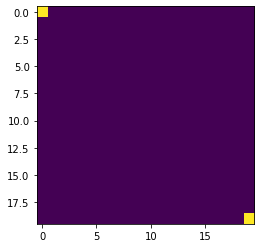

In [186]:
plt.imshow(np.real(Anew - A))

In [182]:
print((Anew-A)[0,0])

(7.888609052210118e-31+0j)


In [184]:
N = 400
%timeit AkBkAngle(10**2, 10**2, np.radians(18), np.radians(30), N=N, J=J, S=S, h=h, eps=eps, a=a, mu=mu)
%timeit AkBkAngleVector(10**2, 10**2, np.radians(18), np.radians(30), N=N, J=J, S=S, h=h, eps=eps, a=a, mu=mu)

7.5 s ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
389 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
N=4
mat = np.random.rand(N,N)
mat2 = np.triu(mat) + np.triu(mat, 1).T.conj()
print(mat-mat2)

[[ 0.          0.          0.          0.        ]
 [-0.48131012  0.          0.          0.        ]
 [-0.33037356 -0.01782293  0.          0.        ]
 [-0.13451844  0.57313247  0.34235917  0.        ]]


In [41]:
np.triu(mat, 1).T.conj()

array([[0.        , 0.        , 0.        , 0.        ],
       [0.78917233, 0.        , 0.        , 0.        ],
       [0.72285356, 0.1032585 , 0.        , 0.        ],
       [0.92330392, 0.38612869, 0.32289859, 0.        ]])

In [42]:
mat

array([[0.82733421, 0.78917233, 0.72285356, 0.92330392],
       [0.30786221, 0.29852557, 0.1032585 , 0.38612869],
       [0.39248   , 0.08543557, 0.47113617, 0.32289859],
       [0.78878547, 0.95926116, 0.66525776, 0.32979   ]])

In [56]:
np.triu(mat, 1).T.conj().shape

(4, 4)

In [66]:
a = np.random.rand(400, 400)
%timeit a[:,10] += np.random.rand(400)
a = np.random.rand(400, 400)
%timeit a[10,:] += np.random.rand(400)
a = np.random.rand(400, 400)
%timeit a[:] += np.diag(np.random.rand(400))

13.5 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
12.3 µs ± 651 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.09 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
